In [17]:
import csv
import pandas as pd
import datetime as datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import dateutil.parser
import re
import pytz
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [18]:
# Load the data

# Load the actual values from the automatic weather observation system (SMN) in Zollikofen. 
df_smn = pd.read_csv('data/smn.csv')

# Load the values from the 5 day weather forecast.

# Meteo Schweiz
df_meteoschweiz = pd.read_csv('data/meteoschweiz.csv')
df_meteoschweiz_symbs = pd.read_csv('data/meteoschweiz_symb.csv')

# SRF Meteo
df_srf = pd.read_csv('data/srf.csv')

# Meteotest
df_meteotest = pd.read_csv('data/meteotest.csv')

# Meteonews
df_meteonews = pd.read_csv('data/meteonews.csv')

In [19]:
df_smn.tail()

,code,dateTime,gustPeak,humidity,windSpeed,windDirection,qnhPressure,temperature,precipitation,sunshine,qfePressure,qffPressure
2043,BER,2016-08-18T19:30:00.000Z,10.4,93.0,5.0,33.0,1013.6,17.4,0.1,0.0,948.7,1011.9
2044,BER,2016-08-18T19:40:00.000Z,6.8,94.0,3.6,26.0,1013.7,17.4,0.0,0.0,948.8,1012.0
2045,BER,2016-08-18T19:50:00.000Z,4.3,93.0,2.9,171.0,1013.7,17.5,0.0,0.0,948.8,1011.9
2046,BER,2016-08-18T20:00:00.000Z,4.3,95.0,2.5,235.0,1013.9,17.3,0.0,0.0,949.0,1012.2
2047,BER,2016-08-18T20:10:00.000Z,3.6,94.0,1.1,287.0,1014.0,17.5,0.0,0.0,949.1,1012.3


In [20]:
# Preprocess the data. 

# Convert the time column to index (time series) 
def parse_date(str_date):
    temp = dateutil.parser.parse(str_date)
    try:
        return pytz.utc.localize(temp)
    except ValueError: 
        return temp

def drop_degree(str_deg):
    temp = re.search(r'\d+',str_deg)
    return float(temp.group(0))

# SMN
df_smn['time'] = df_smn['dateTime'].apply(parse_date)
df_smn.index = df_smn['time']
df_smn = df_smn.drop('time',axis=1)
df_smn = df_smn.drop('dateTime',axis=1)

# Meteonews
df_meteonews['time'] = df_meteonews['time'].apply(parse_date)
df_meteonews.index = df_meteonews['time']
df_meteonews = df_meteonews.drop('time',axis=1)

# SRF
df_srf['time'] = df_srf['time'].apply(parse_date)
df_srf.index = df_srf['time']
df_srf = df_srf.drop('time',axis=1)
df_srf['temp'] = df_srf['temp'].apply(drop_degree)

# Meteotest
df_meteotest['date'] = df_meteotest['date'].apply(parse_date)
df_meteotest.index = df_meteotest['date']
df_meteotest = df_meteotest.drop('date',axis=1)

# Meteo Schweiz
df_meteoschweiz.columns = ['time','temp','rain']
df_meteoschweiz['time'] = df_meteoschweiz['time'].apply(parse_date)
df_meteoschweiz.index = df_meteoschweiz['time']
df_meteoschweiz = df_meteoschweiz.drop('time',axis=1)

df_meteoschweiz_symbs.columns = ['time','symb']
df_meteoschweiz_symbs['time'] = df_meteoschweiz_symbs['time'].apply(parse_date)
df_meteoschweiz_symbs.index = df_meteoschweiz_symbs['time']
df_meteoschweiz_symbs = df_meteoschweiz_symbs.drop('time',axis=1)

In [21]:
# Merge the datasets

# SMN and Meteonews
df = pd.merge(df_smn, df_meteonews, right_index=True, left_index=True, how='outer')
df = df[['temperature','temp']]
df.columns = ['temp_smn','temp_meteonews']

# Adding Meteotest
df = pd.merge(df, df_meteotest, right_index=True, left_index=True, how='outer')
df = df[['temp_smn','temp_meteonews','temp']]
df.columns = ['temp_smn','temp_meteonews','temp_meteotest']

# Adding MeteoSchweiz
df = pd.merge(df, df_meteoschweiz, right_index=True, left_index=True, how='outer') # Why??
df = df[['temp_smn', 'temp_meteonews', 'temp_meteotest', 'temp']]
df.columns = ['temp_smn', 'temp_meteonews', 'temp_meteotest', 'temp_meteoschweiz']

# Adding SRF
df = pd.merge(df, df_srf, right_index=True, left_index=True, how='outer')
df = df[['temp_smn','temp_meteonews','temp_meteotest', 'temp_meteoschweiz', 'temp']]
df.columns = ['temp_smn','temp_meteonews','temp_meteotest', 'temp_meteoschweiz', 'temp_srf']

In [22]:
df.count()

temp_smn             2122
temp_meteonews        137
temp_meteotest        385
temp_meteoschweiz     285
temp_srf              123
dtype: int64

## Graphs

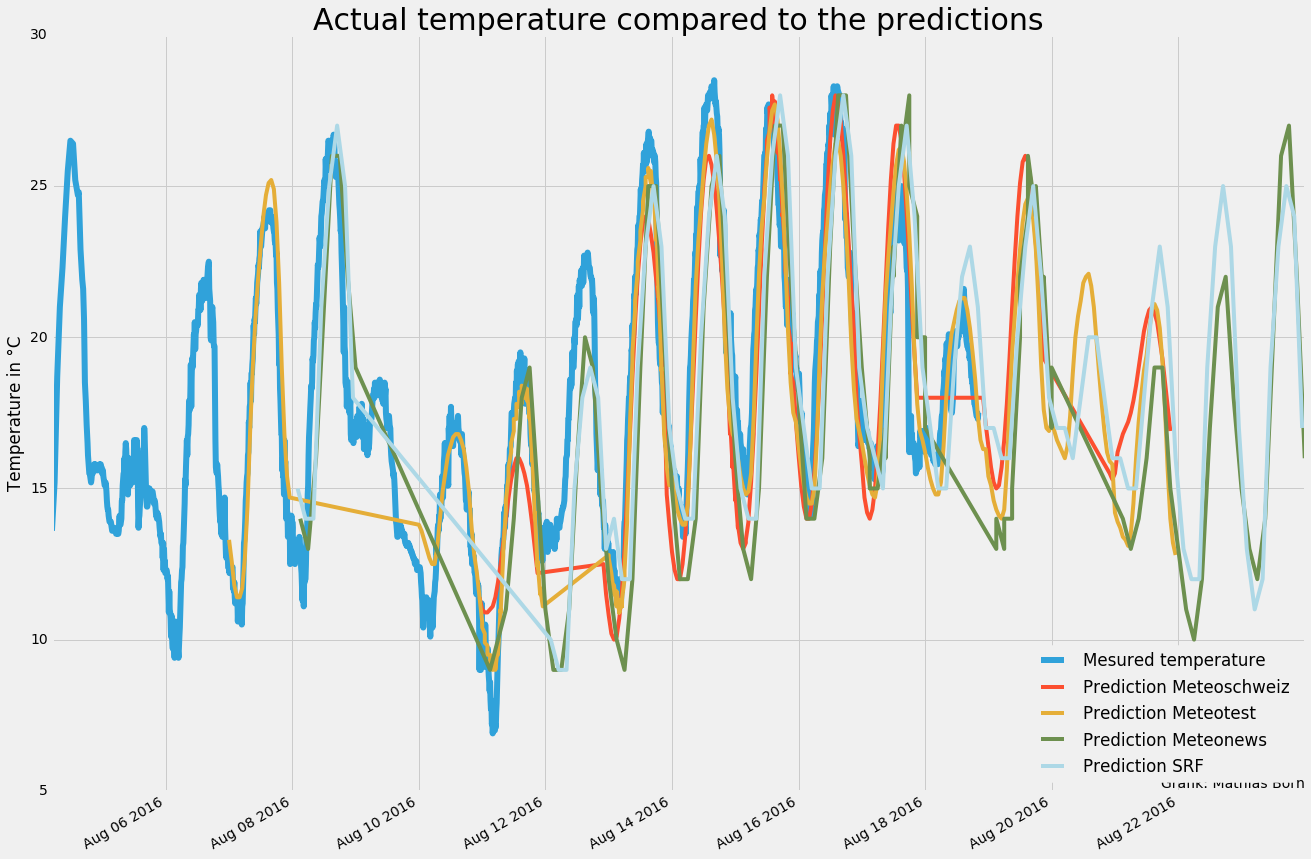

In [23]:
# Initialize the plot first, take the ax
fig, ax = plt.subplots(figsize=(20,15))

# Pass the ax to the .plot function
df['temp_smn'].dropna().plot(kind='line', label='Mesured temperature', legend=True, linewidth=6, ax=ax)
df['temp_meteoschweiz'].dropna().plot(kind='line', label='Prediction Meteoschweiz', legend=True, ax=ax)
df['temp_meteotest'].dropna().plot(kind='line', label='Prediction Meteotest', legend=True, ax=ax)
df['temp_meteonews'].dropna().plot(kind='line', label='Prediction Meteonews', legend=True, ax=ax)
df['temp_srf'].dropna().plot(kind='line', label='Prediction SRF', color='lightblue', legend=True, ax=ax)

ax.set_ylabel("Temperature in °C")
ax.set_title("Actual temperature compared to the predictions", fontsize=30)
ax.annotate('Grafik: Mathias Born', xy=(1, 0), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

fig.savefig('output/temperature.png')

## Calculate offset

In [27]:
# Calculating the offset in degrees.

df['temp_offset_meteonews'] = df['temp_smn'] - df['temp_meteonews']
df['temp_offset_meteotest'] = df['temp_smn'] - df['temp_meteotest']
df['temp_offset_meteoschweiz'] = df['temp_smn'] - df['temp_meteoschweiz']
df['temp_offset_srf'] = df['temp_smn'] - df['temp_srf']

In [28]:
# Calculating the offset in percent.

df['temp_offset_meteonews_percent'] = abs(100 * df['temp_offset_meteonews'] / df['temp_smn'])
df['temp_offset_meteotest_percent'] = abs(100 * df['temp_offset_meteotest'] / df['temp_smn'])
df['temp_offset_meteoschweiz_percent'] = abs(100 * df['temp_offset_meteoschweiz'] / df['temp_smn'])
df['temp_offset_srf'] = abs(100 * df['temp_offset_srf'] / df['temp_smn'])

In [29]:
df[['temp_offset_meteonews_percent','temp_offset_meteotest_percent', 'temp_offset_meteoschweiz_percent', 'temp_offset_srf']].describe()

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,temp_offset_meteonews_percent,temp_offset_meteotest_percent,temp_offset_meteoschweiz_percent,temp_offset_srf
count,84.000000,295.000000,224.000000,81.000000
mean,16.305862,6.834505,11.417921,13.571705
std,13.966064,6.040922,9.448003,10.711776
min,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,72.839506,44.444444,60.869565,48.148148


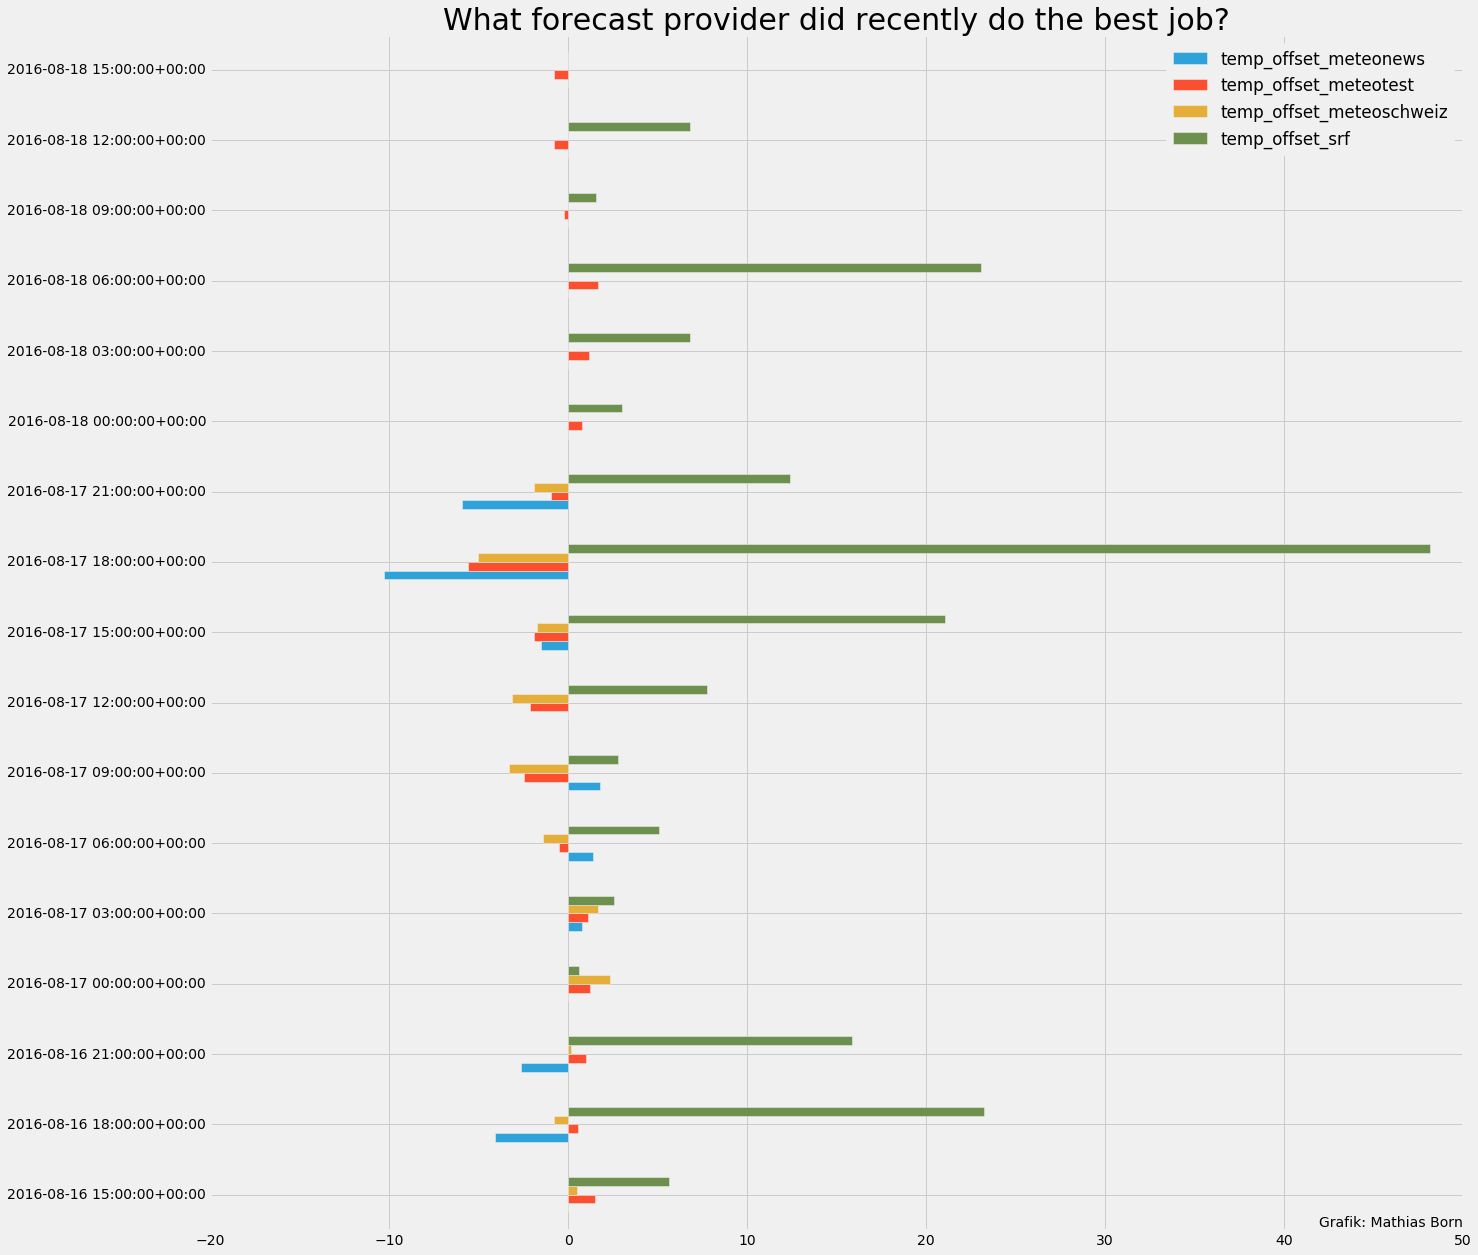

In [30]:
time1 = str(datetime.datetime.now() - timedelta(days=2))
time2 = str(datetime.datetime.now())

# Initialize the plot first, take the ax
fig, ax = plt.subplots(figsize=(20,20))

# Pass the ax to the .plot function
df[time1:time2][['temp_offset_meteonews','temp_offset_meteotest', 'temp_offset_meteoschweiz', 'temp_offset_srf']].resample('3H').mean().plot(ax=ax, label=['Offset Meteonews', 'Offset Meteotest', 'Offset Meteoschweiz', 'Offset SRF'], legend=True, kind='barh')
ax.set_title("What forecast provider did recently do the best job?", fontsize=30)
ax.annotate('Grafik: Mathias Born', xy=(1, 0), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

fig.savefig('output/offset.png')